In [2]:
import feedparser
import DCDSFunctions as f
import pandas as pd
import pickle
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

<b> H1B1 Data Information </b>

In [3]:
# H1BDATA.info
import requests
from bs4 import BeautifulSoup
import time
import random

In [4]:
# Sample query
years = list(range(2014,2020))
years = [str(y) for y in years]
years

['2014', '2015', '2016', '2017', '2018', '2019']

In [1]:
# Scrap Job Title Information

# job_title_url = 'https://h1bdata.info/topjobs.php'
# title_resp = requests.get(job_title_url)

# titles_all = BeautifulSoup(title_resp.content, 'html.parser') # soup type
# title_block = titles_all.find('tbody') # element.Tag
# title_rows = title_block.findAll('tr') # element.ResultSet which is a list of Tags
# title_links= [x.findAll('a') for x in title_rows] # list of list each with one element.Tag
# title_data = [x[0].get_text()  for x in title_links if x]

# DS_titles = [x.lower().replace(' ','+') for x in title_data if 'DATA SCI' in x]

In [6]:
# Manual Save Path Keywords based on DS_titles above
save_titles= ['DSgen','SeniorDS','AssocDS','DSII','DSI','SrDS','LeadDS','DSEng','DSAnalyst','SenAssocDS']

In [3]:
# Scrape Job Information and Pickle

# for ind,title in enumerate(DS_titles):
#     save_title = save_titles[ind]

#     for year in years:
#         h1b1_url = 'https://h1bdata.info/index.php?em=&job='+title+'&city=&year='+year

#         resp = requests.get(h1b1_url)

#         h1b1_annual = BeautifulSoup(resp.content, 'html.parser')
#         block = h1b1_annual.find('tbody')
#         data = block.findAll('tr')
#         t = [x.findAll('td') for x in data]

#         col = ['Company','Role','Salary','Location','SubmitDate','StartDate','Status']
#         ls = []
#         for row in t:
#             vals = [x.text for x in row]
#             dic = dict(zip(col,vals))
#             ls.append(dic)

#         h1b1 = pd.DataFrame(ls)
#         pause = random.randrange(3,15)
#         print('Pausing for ',pause,' seconds...')
#         time.sleep(pause)

#         filename = 'data/h1b1data_'+save_title+'_'+year+'.p'
#         outfile = open(filename,'wb')
#         pickle.dump(h1b1,outfile)
#         outfile.close()

In [36]:
# Load data and merge to one DataFrame

h1b1_all = pd.DataFrame()

for ind,title in enumerate(save_titles):
    
    for i, year in enumerate(years):
        
        filename = 'data/h1b1data_'+title+'_'+year+'.p'
        infile = open(filename,'rb')
        t = pickle.load(infile)
        t['Year'] = year

        if ((ind == 0) & (i == 0)):
            h1b1_all = t
        elif sum(t.shape)>=1:
            h1b1_all = pd.concat([h1b1_all,t], ignore_index=True, sort=True)
            

In [37]:
h1b1_all.Salary = h1b1_all.Salary.map(lambda x: x.replace(',','')).map(int)
h1b1_all.Year = h1b1_all.Year.map(int)

In [35]:
h1b1_all.Role.unique()

array(['DATA SCIENTIST', 'SENIOR DATA SCIENTIST',
       'ASSOCIATE DATA SCIENTIST', 'DATA SCIENTIST II',
       'DATA SCIENTIST I', 'LEAD DATA SCIENTIST',
       'DATA SCIENTIST ENGINEER', 'DATA SCIENTIST ANALYST',
       'SENIOR ASSOCIATE, DATA SCIENTIST'], dtype=object)

In [10]:
# Group Senior Role Titles
h1b1_all.Role = h1b1_all.Role.map(lambda x: x.replace('SR. DATA SCIENTIST','SENIOR DATA SCIENTIST'))
h1b1_all.Role = h1b1_all.Role.map(lambda x: x.replace('DATA SCIENCE','DATA SCIENTIST'))
h1b1_all.Role = h1b1_all.Role.map(lambda x: x.replace('SENIOR ASSOCIATE, DATA SCIENCE','ASSOCIATE DATA SCIENTIST')) # only from capital one

In [11]:
h1b1 = h1b1_all[h1b1_all['Status'] == 'CERTIFIED'].reset_index(drop = True)

print( str( round( len(h1b1) / len(h1b1_all)*100, 1)) + '%')

95.6%


In [12]:
h1b1[h1b1['Salary']>300000]

,Company,Location,Role,Salary,StartDate,Status,SubmitDate,Year
2722,LARSON LIVING LABS LLC,"CAMBRIDGE, MA",DATA SCIENTIST,312000,03/28/2018,CERTIFIED,03/21/2018,2018
2723,LARSON LIVING LABS LLC,"CAMBRIDGE, MA",DATA SCIENTIST,312000,06/01/2018,CERTIFIED,05/14/2018,2018


In [13]:
h1b1[h1b1['Salary']<40000]

,Company,Location,Role,Salary,StartDate,Status,SubmitDate,Year
76,THREATMETRIX INC,"SAN JOSE, CA",DATA SCIENTIST,5769,01/26/2015,CERTIFIED,01/06/2015,2015
615,DOMINION ENTERPRISES,"NORFOLK, VA",DATA SCIENTIST,29973,08/31/2016,CERTIFIED,03/01/2016,2016
1489,UBER TECHNOLOGIES INC,"PITTSBURGH, PA",DATA SCIENTIST,37482,06/01/2017,CERTIFIED,01/13/2017,2017


In [14]:
# Drop Outliers
before_drop = len(h1b1)

h1b1 = h1b1[h1b1['Salary']>40000]# three values, likely typos or atypical contracts
h1b1 = h1b1[h1b1['Salary']<300000] # two values, larson living labs
h1b1 = h1b1.drop_duplicates()# several repeat entries

print( str( round(  before_drop/ len(h1b1_all)*100, 1)) + '%')

95.6%


In [22]:
# Save to CSV
h1b1.to_csv('H1B_DataScience_Salaries_V1.csv', index = False)

In [38]:
h1b1 = pd.read_csv('H1B_DataScience_Salaries_V1.csv')

<b> Let's plot </b>

In [39]:
pd.pivot_table(h1b1,values='Status',columns = 'Role',index = 'Year',aggfunc = 'count')

Role,ASSOCIATE DATA SCIENTIST,DATA SCIENTIST,DATA SCIENTIST ANALYST,DATA SCIENTIST ENGINEER,DATA SCIENTIST I,DATA SCIENTIST II,LEAD DATA SCIENTIST,"SENIOR ASSOCIATE, DATA SCIENTIST",SENIOR DATA SCIENTIST
Year,,,,,,,,,
2014,NaN,67.0,NaN,NaN,NaN,NaN,2.0,NaN,13.0
2015,13.0,514.0,4.0,5.0,3.0,7.0,8.0,NaN,103.0
2016,29.0,830.0,12.0,13.0,15.0,21.0,18.0,12.0,150.0
2017,38.0,1171.0,46.0,19.0,18.0,29.0,31.0,5.0,223.0
2018,60.0,1898.0,32.0,43.0,50.0,61.0,46.0,32.0,397.0
2019,80.0,1522.0,16.0,48.0,80.0,198.0,141.0,13.0,409.0


In [50]:
area_data = [[0,67,0,0,0,0,2,0,13] ,
             [13,514,4,5,3,7,8,0,103] , 
             [29,830,12,13,15,21,18,12,150], 
             [38,1171,46,19,18,29,31,5,223], 
             [60,1898,32,43,50,61,46,32,397], 
             [80,1522,16,48,80,198,141,13,409] ]
area_data_T = list(map(list, zip(*area_data)))
area_data_T

[[0, 13, 29, 38, 60, 80],
 [67, 514, 830, 1171, 1898, 1522],
 [0, 4, 12, 46, 32, 16],
 [0, 5, 13, 19, 43, 48],
 [0, 3, 15, 18, 50, 80],
 [0, 7, 21, 29, 61, 198],
 [2, 8, 18, 31, 46, 141],
 [0, 0, 12, 5, 32, 13],
 [13, 103, 150, 223, 397, 409]]

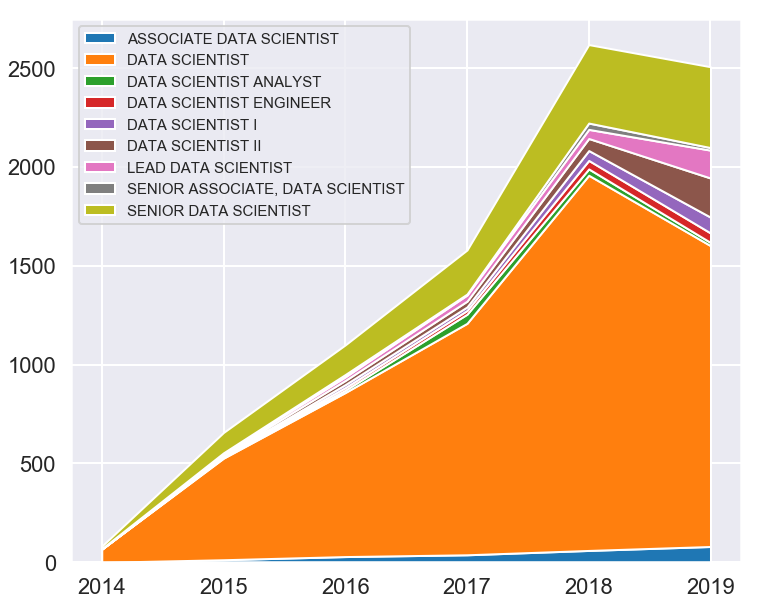

In [54]:
fig = plt.figure(figsize = (12,10))
ax = plt.stackplot(years,area_data_T, labels = ['ASSOCIATE DATA SCIENTIST','DATA SCIENTIST','DATA SCIENTIST ANALYST',
                                              'DATA SCIENTIST ENGINEER', 'DATA SCIENTIST I','DATA SCIENTIST II',
                                              'LEAD DATA SCIENTIST','SENIOR ASSOCIATE, DATA SCIENTIST' ,
                                              'SENIOR DATA SCIENTIST'])
plt.legend(fontsize = 15, loc='upper left')
plt.show()
fig.savefig("./images/h1b1_applications_byrole_stacked_area.png")


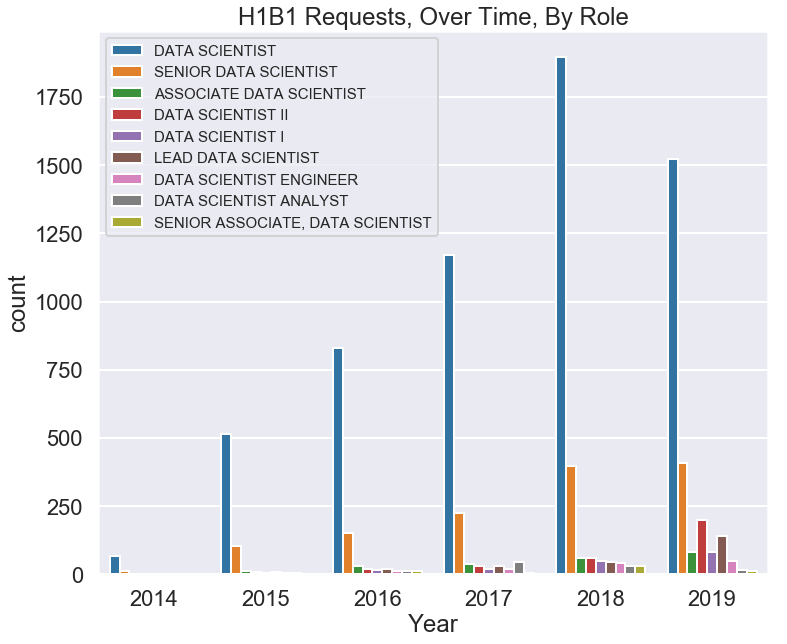

In [24]:
fig = plt.figure(figsize = (12,10))

ax = sns.countplot(x = 'Year', data = h1b1, hue = 'Role')
# ax = plt.stackplot(years[1:],area_data, labels = save_titles)
plt.title('H1B1 Requests, Over Time, By Role')
plt.legend(fontsize = 15, loc='upper left')

# sns.set_context('poster')
# sns.set_style("darkgrid")

fig.savefig("./images/h1b1_applications_byrole.png")
plt.show()

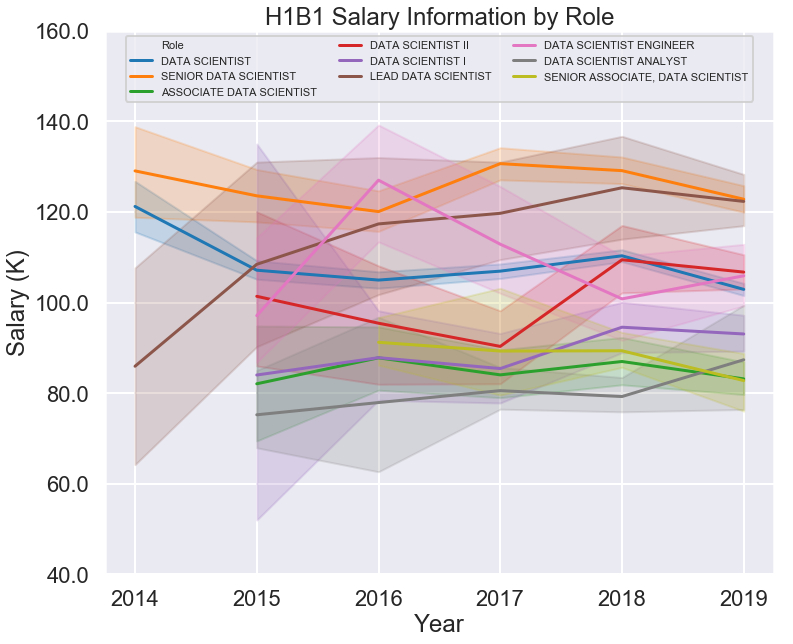

In [53]:
fig = plt.figure(figsize = (12,10))
ax = sns.lineplot(x="Year", y="Salary", data=h1b1, hue = 'Role')

locs,labels = plt.yticks()
ticks = ax.get_yticks()
plt.ylabel('Salary (K)')
plt.yticks(locs, ticks/1000)
plt.title('H1B1 Salary Information by Role')

plt.legend(ncol = 3, fontsize = 11, loc='upper center')

sns.set_context('poster')
sns.set_style("darkgrid")

fig.savefig("images/h1b1_salaries_byrole.png")
plt.show()

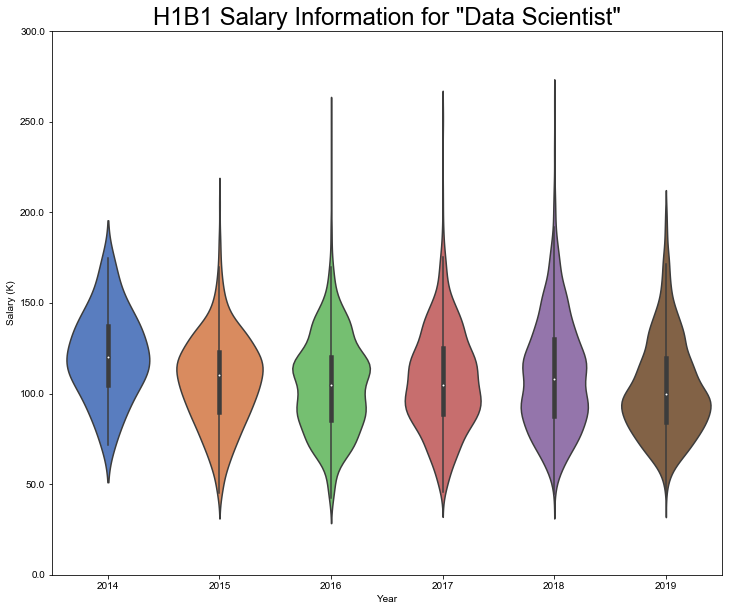

In [18]:
fig = plt.figure(figsize = (12,10))
ax = sns.violinplot(x="Year", y="Salary", data=h1b1[h1b1['Role']=='DATA SCIENTIST'], palette="muted")
locs,labels = plt.yticks()
ticks = ax.get_yticks()
plt.ylabel('Salary (K)')
plt.yticks(locs, ticks/1000)
sns.set_context('poster')
sns.set_style("darkgrid")
plt.title('H1B1 Salary Information for "Data Scientist"')
# fig.savefig("images/h1b1_violin.png")
plt.show()

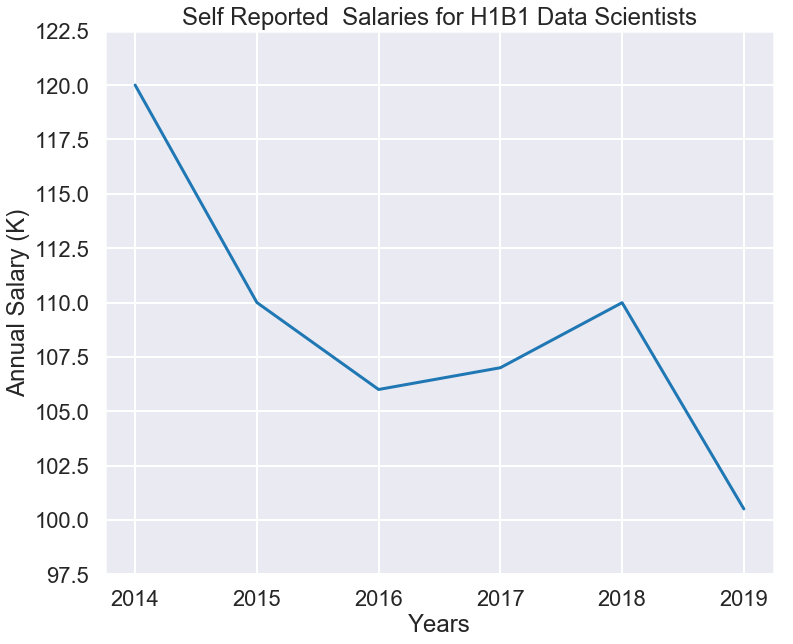

In [19]:
fig = plt.figure(figsize = (12,10))
ax = sns.lineplot(years,h1b1.groupby('Year').Salary.median())
locs,labels = plt.yticks()
ticks = ax.get_yticks()
plt.yticks(locs, ticks/1000)
plt.xlabel('Years')
plt.ylabel('Annual Salary (K)')
plt.title('Self Reported  Salaries for H1B1 Data Scientists')
fig.savefig("images/h1b1_median.png")
plt.show()

In [ ]:
# Break out by industry and location

In [20]:
h1b1.loc[h1b1.Location.map(lambda x: ', MD' in x)].Location.sort_values().unique()

array(['BALTIMORE, MD', 'BETHESDA, MD', 'COLUMBIA, MD',
       'ELLICOTT CITY, MD', 'FREDERICK, MD', 'GAITHERSBURG, MD',
       'GERMANTOWN, MD', 'LINTHICUM, MD', 'OLNEY, MD', 'ROCKVILLE, MD',
       'SILVER SPRING, MD', 'TOWSON, MD', 'WEST NEW YORK, MD'],
      dtype=object)

In [26]:
# Create Regional Tags

# Example
h1b1.loc[h1b1.Location.map(lambda x: ', CA' in x)].Location.unique()
h1b1.loc[h1b1.Location.map(lambda x: ', NY' in x)].Location.unique()


bay_area = ['ALAMEDA, CA', 'BELMONT, CA', 'BENICIA, CA', 'BERKELEY, CA', 'BRISBANE, CA', 'BURLINGAME, CA', 'CAMPBELL, CA',
       'CUPERTINO, CA', 'DUBLIN, CA', 'EAST PALO ALTO, CA','EL CERRITO, CA', 'EMERYVILLE, CA', 'FOLSOM, CA',
       'FOSTER CITY, CA', 'FREMONT, CA',  'HERCULES, CA', 'LOS ALTOS, CA', 'LOS GATOS, CA', 'MENLO PARK, CA',
       'MILL VALLEY, CA', 'MILLBRAE, CA', 'MILPITAS, CA', 'MOUNTAIN VIEW, CA', 'NEWARK, CA', 'NOVATO, CA',
       'OAKLAND, CA', 'PALO  ALTO, CA', 'PALO ALTO, CA', 'PASADENA, CA', 'PETALUMA, CA', 'PLEASANT HILL, CA', 'PLEASANTON, CA',
       'REDLANDS, CA', 'REDWOOD CITY, CA', 'REDWOOD SHORES, CA', 'RICHMOND, CA', 'SAN BRUNO, CA', 'SAN CARLOS, CA',
       'SAN FANCISCO, CA', 'SAN FRANCICSCO, CA', 'SAN FRANCISCO, CA', 'SAN FRANCISCO, CA, CA', 'SAN JOSE, CA',  'SAN MATEO, CA',
       'SAN RAMON, CA', 'SANJOSE, CA', 'SAUSALITO, CA', 'SOUTH SAN FRANCISCO, CA', 'SUNNYVALE, CA', 'TIBURON, CA', 'UNION CITY, CA',
       'VALLEJO, CA', 'VENICE, CA', 'WALNUT CREEK, CA','SAN FRANCISCO, VA']



# bay_area = ['MOUNTAIN VIEW, CA', 'FREMONT, CA', 'SAN JOSE, CA', 'SAN FRANCISCO, CA', 'SAN MATEO, CA', 'MILPITAS, CA', 'PALO ALTO, CA', 'FOSTER CITY, CA', 'HOLLYWOOD, CA',
#         'MENLO PARK, CA', 'SANTA CLARA, CA', 'SAN CARLOS, CA', 'REDWOOD CITY, CA', 'CAMPBELL, CA', 'SUNNYVALE, CA', 'MILL VALLEY, CA',  'SAN FRANCISCO, CA, CA', 'EMERYVILLE, CA',
#         'CUPERTINO, CA', 'LOS ALTOS, CA', 'SAN BRUNO, CA', 'BURLINGAME, CA', 'BERKELEY, CA', 'NEWARK, CA', 'SAN FRANCICSCO, CA', 'PALO  ALTO, CA', 'OAKLAND, CA', 
#         'MILLBRAE, CA', 'DUBLIN, CA', 'SAUSALITO, CA', 'REDWOOD SHORES, CA', 'BRISBANE, CA', 'WALNUT CREEK, CA','NOVATO, CA', 'EAST PALO ALTO, CA', 'SANJOSE, CA','EL CERRITO, CA', 
#         'VALLEJO, CA', 'UNION CITY, CA', 'TIBURON, CA', 'LAFAYETTE, CA', 'SOUTH SAN FRANCISCO, CA', 'MODESTO, CA', 'RICHMOND, CA', 'BELMONT, CA', 'PLEASANT HILL, CA', 'SAN FANCISCO, CA',
#         'ALAMEDA, CA', 'TUSTIN, CA', 'PETALUMA, CA', 'REDLANDS, CA', 'AUSTIN, CA','LOS GATOS, CA','SAN FRANCISCO, VA']

nyc = ['NEW YORK, NY',  'BROOKLYN, NY', 'NEW  YORK, NY', 'NEW YORK CITY, NY', 'IRVINGTON, NY', 'LONG ISLAND CITY, NY', 'NYC, NY']
longisland = ['EAST MEADOW, NY','FARMINGDALE, NY', 'PORT WASHINGTON, NY','LONG BEACH, NY', 'MELVILLE, NY','LYNBROOK, NY','JERICHO, NY', 'UNIONDALE, NY']
westchester= ['ARMONK, NY','WHITE PLAINS, NY',  'YONKERS, NY','TARRYTOWN, NY','SPRING VALLEY, NY', 'SOMERS, NY','SOMMERS, NY','VALHALLA, NY','SOMERS, NY', 'YORKTOWN HEIGHTS, NY','YORKTOWN HIEGHTS, NY','WOODBURY, NY']

dmv = ['WASHINGTON, DC', 'WASHINGTON, DC, DC', 'WASHINGTON DC, DC','MCLEAN, VA','RETSON, VA', 'STERLING, VA', 'ALEXANDRIA, VA', 'ARLINGTON, VA', 'HERNDON, VA', 'ASHBURN, VA', 'MANASSAS, VA', 'RESTON, VA', 
    'FALLS CHURCH, VA','FAIRFAX, VA', 'DULLES, VA','BETHESDA, MD', 'SILVER SPRING, MD','COLUMBIA, MD','ROCKVILLE, MD']

# Add a columns for the split

h1b1['SV0_NYC1'] = [0  if x in bay_area else 1 if x in nyc else None for x in h1b1.Location]

h1b1['SV0_DMV2'] = [0  if x in bay_area else 2 if x in dmv else None for x in h1b1.Location]

h1b1['NYC1_DMV2'] = [2  if x in dmv else 1 if x in nyc else None for x in h1b1.Location]

In [27]:
h1b1_DS = h1b1[h1b1['Role']=='DATA SCIENTIST']
h1b1_DS.shape

(6002, 11)

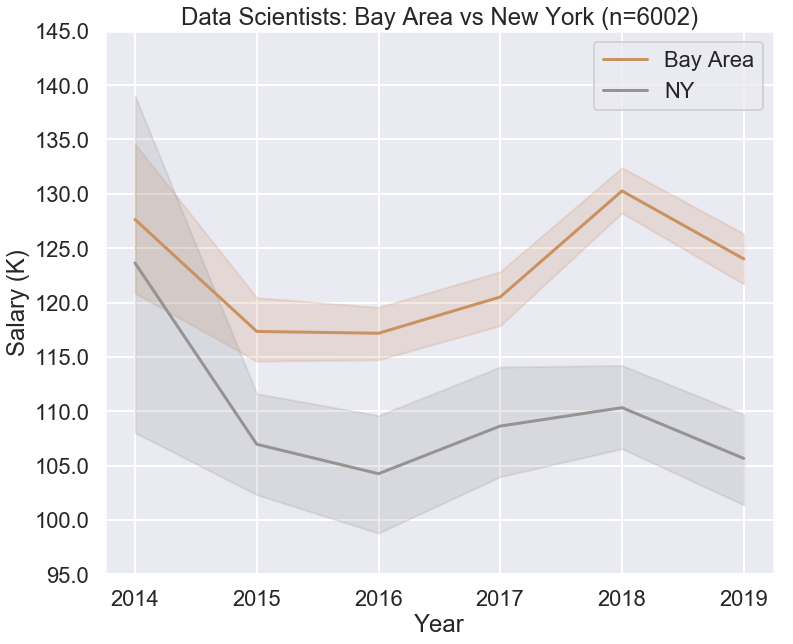

In [28]:
# Bay Area versus NY

fig = plt.figure(figsize = (12,10))
ax = sns.lineplot(x="Year", y="Salary", data=h1b1[h1b1['Role']=='DATA SCIENTIST'], palette={0.0: sns.color_palette('colorblind')[5], 1.0: sns.color_palette('colorblind')[7]}, hue='SV0_NYC1')
locs,labels = plt.yticks()
ticks = ax.get_yticks()
plt.ylabel('Salary (K)')
plt.yticks(locs, ticks/1000)
sns.set_context('poster')
sns.set_style("darkgrid")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:],['Bay Area','NY'])

n_data = len(h1b1[h1b1['Role']=='DATA SCIENTIST'])

plt.title(f'Data Scientists: Bay Area vs New York (n={n_data})')
fig.savefig("images/h1b1_DSgen_NYC_SV.png")
plt.show()

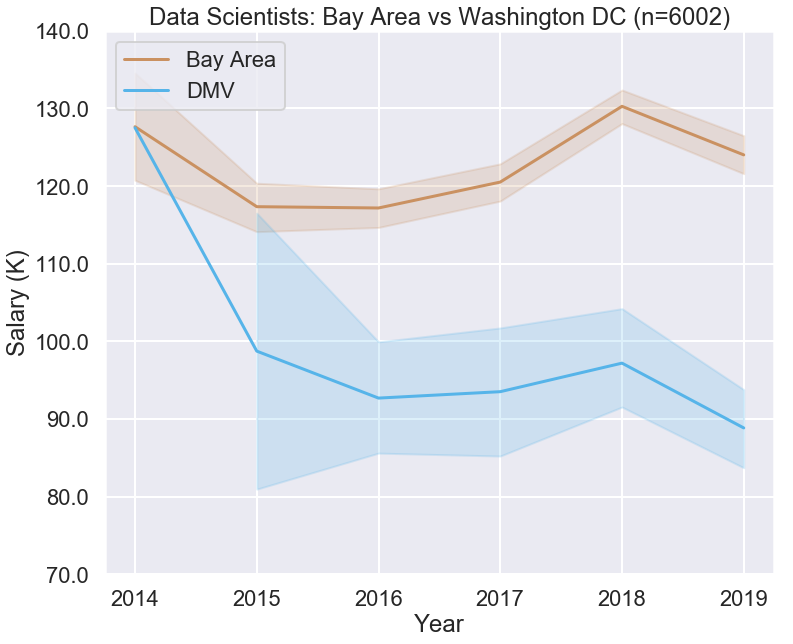

In [29]:
fig = plt.figure(figsize = (12,10))

ax = sns.lineplot(x="Year", y="Salary", data=h1b1[h1b1['Role']=='DATA SCIENTIST'], palette={0.0: sns.color_palette('colorblind')[5], 2.0: sns.color_palette('colorblind')[9]}, hue='SV0_DMV2')
locs,labels = plt.yticks()
ticks = ax.get_yticks()
plt.ylabel('Salary (K)')
plt.yticks(locs, ticks/1000)
sns.set_context('poster')
sns.set_style("darkgrid")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:],['Bay Area','DMV'])

n_data = len(h1b1[h1b1['Role']=='DATA SCIENTIST'])

plt.title(f'Data Scientists: Bay Area vs Washington DC (n={n_data})')
fig.savefig("images/h1b1_DSgen_DMV_SV.png")
plt.show()

In [75]:
fig = plt.figure(figsize = (12,10))
ax = sns.lineplot(x="Year", y="Salary", data=h1b1[h1b1['Role']=='DATA SCIENTIST'], palette={1.0: sns.color_palette('colorblind')[7], 2.0: sns.color_palette('colorblind')[9]}, hue='NYC1_DMV2')
locs,labels = plt.yticks()
ticks = ax.get_yticks()
plt.ylabel('Salary (K)')
plt.yticks(locs, ticks/1000)
sns.set_context('poster')
sns.set_style("darkgrid")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:],['NYC','DMV'])


n_data = len(h1b1[h1b1['Role']=='DATA SCIENTIST'])

plt.title(f'Data Scientists: NYC vs Washington DC (n={n_data})')
fig.savefig("images/h1b1_DSgen_NYC_DMV.png")
plt.show()

ValueError: Could not interpret input 'NYC1_DMV2'

<Figure size 864x720 with 0 Axes>